In [1]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import shap

# Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE

# Model Performance Metrics
from sklearn.metrics import (
    confusion_matrix, accuracy_score, classification_report, 
    roc_auc_score, precision_score, 
    recall_score, f1_score, r2_score
)

# Model Selection and Validation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV

#Model Interpretability
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from pycebox.ice import ice, ice_plot
from PyALE import ale

# Classification Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier

# Statistical and Mutual Information
from scipy.stats import pearsonr, mode
from sklearn.metrics import mutual_info_score
from skopt.space import Real, Integer

# Optimization
from scipy.optimize import minimize

# Deep Learning
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import BinaryCrossentropy

c:\Users\soory\Documents\Masters\Projects\Report\credit_risk\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_excel('values_final.xlsx')

In [3]:
# Create test set for the year 2023
test_data = df[df['Year'] == 2023]

# Create training set for years 2013 to 2022
train_data = df[df['Year'] < 2023]

# Define your features (X) and target (y)
# Replace 'Target' with the actual name of your target column
X_train = train_data.drop(['Default'], axis=1)  # Remove the target column for training
y_train = train_data['Default']  # Define target for training

X_test = test_data.drop(['Default'], axis=1)  # Remove the target column for testing
y_test = test_data['Default']  # Define target for testing

# Optionally, check the shapes of the resulting sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (500, 30) (500,)
Test set shape: (50, 30) (50,)


In [4]:
X_train_scaled = X_train.iloc[:, 3:]
X_test_scaled = X_test.iloc[:, 3:]

In [5]:
X_train_scaled = X_train_scaled + 1e-9
entropy = -np.sum(X_train_scaled * np.log(X_train_scaled), axis=0)

c:\Users\soory\Documents\Masters\Projects\Report\credit_risk\lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


In [6]:
weights = entropy / np.sum(entropy)
weights_expanded = np.expand_dims(weights, axis=(0, 1))
# print(weights_expanded)
abs_difference = np.abs(X_train_scaled.to_numpy()[:, :, np.newaxis] - 
                        X_train_scaled.to_numpy()[:, np.newaxis, :])

# print("Shape of abs_difference:", abs_difference.shape)

grey_correlation_matrix = np.sum(weights_expanded * abs_difference, axis=0) / np.sum(weights)
# print("Grey Correlation Matrix:")
# print(grey_correlation_matrix)
grey_correlation_df = pd.DataFrame(grey_correlation_matrix, index=X_train_scaled.columns, columns=X_train_scaled.columns)
average_correlation = grey_correlation_df.mean(axis=1)
ranked_indicators = average_correlation.sort_values(ascending=False)
print("Ranked Financial Indicators:")
print(ranked_indicators)

Ranked Financial Indicators:
Earnings Yield              40.898158
FCF Yield                   40.887999
Return on Capital (ROIC)    40.822276
Return on Assets (ROA)      40.630051
Return on Equity (ROE)      40.538700
Dividend Yield              39.831771
Total Shareholder Return    39.596388
Buyback Yield / Dilution    38.769304
Payout Ratio                38.036152
Asset Turnover              30.967299
PE Ratio                    26.879006
Debt / Equity Ratio         26.019644
Debt Issuance               24.435816
Current Ratio               23.793030
Quick Ratio                 23.654609
Debt / EBITDA Ratio         22.958168
Debt / FCF Ratio            22.271955
EV/EBIT Ratio               21.637353
EV/FCF Ratio                20.174022
Enterprise Value            19.928121
P/FCF Ratio                 19.544990
Market Capitalization       18.161194
PB Ratio                    17.826360
P/OCF Ratio                 17.482471
EV/EBITDA Ratio             16.814650
EV/Sales Ratio       

In [7]:
pca = PCA()

weighted_X_train_scaled = X_train_scaled * weights

pca.fit(weighted_X_train_scaled)

desired_variance_ratio = 0.95  
num_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= desired_variance_ratio) + 1

print("Number of Principal Components:", num_components)

x_train_pca = pca.transform(weighted_X_train_scaled)[:, :num_components]

weighted_X_test_scaled = X_test_scaled * weights

x_test_pca = pca.transform(weighted_X_test_scaled)[:, :num_components]

Number of Principal Components: 15


## Logistic Regression

In [8]:
logistic = LogisticRegression()
logistic.fit(x_train_pca, y_train)

y_pred = logistic.predict(x_test_pca)
y_pred_proba = logistic.predict_proba(x_test_pca)[:, 1]

conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)
print("ROC AUC Score:", roc_auc)

Confusion Matrix:
 [[31  4]
 [12  3]]
Accuracy: 0.68
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.89      0.79        35
           1       0.43      0.20      0.27        15

    accuracy                           0.68        50
   macro avg       0.57      0.54      0.53        50
weighted avg       0.63      0.68      0.64        50

ROC AUC Score: 0.6247619047619049


## KNN Classifier

k=2: Accuracy=0.7200, Precision=0.6933, Recall=0.7200, F1 Score=0.6675, ROC AUC=0.6171
k=3: Accuracy=0.6200, Precision=0.5800, Recall=0.6200, F1 Score=0.5947, ROC AUC=0.5829
k=4: Accuracy=0.6800, Precision=0.5915, Recall=0.6800, F1 Score=0.5967, ROC AUC=0.5848
k=5: Accuracy=0.6400, Precision=0.5741, Recall=0.6400, F1 Score=0.5930, ROC AUC=0.6076
k=6: Accuracy=0.6600, Precision=0.5620, Recall=0.6600, F1 Score=0.5847, ROC AUC=0.6133
k=7: Accuracy=0.6800, Precision=0.6332, Recall=0.6800, F1 Score=0.6382, ROC AUC=0.5752
k=8: Accuracy=0.7200, Precision=0.6933, Recall=0.7200, F1 Score=0.6675, ROC AUC=0.6190
k=9: Accuracy=0.7200, Precision=0.6924, Recall=0.7200, F1 Score=0.6834, ROC AUC=0.6486


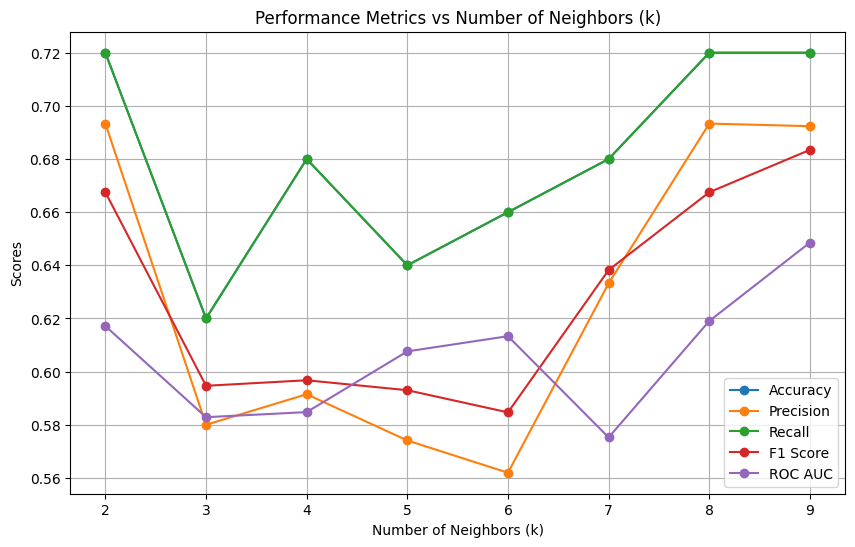

Confusion Matrix:
 [[32  3]
 [11  4]]
Accuracy: 0.72
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.91      0.82        35
           1       0.57      0.27      0.36        15

    accuracy                           0.72        50
   macro avg       0.66      0.59      0.59        50
weighted avg       0.69      0.72      0.68        50

ROC AUC Score: 0.6485714285714286


In [9]:
k_values = range(2, 10)
accuracies = []
precisions = []
recalls = []
f1_scores = []
roc_aucs = []  # List to store ROC AUC scores

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train_pca, y_train)
    y_pred = knn.predict(x_test_pca)
    y_pred_proba = knn.predict_proba(x_test_pca)[:, 1]  # Get predicted probabilities for ROC AUC
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred_proba)  # Calculate ROC AUC score
    
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    roc_aucs.append(roc_auc)  # Store the ROC AUC score

# Print the results
for k, accuracy, precision, recall, f1, roc_auc in zip(k_values, accuracies, precisions, recalls, f1_scores, roc_aucs):
    print(f'k={k}: Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1 Score={f1:.4f}, ROC AUC={roc_auc:.4f}')

# Plot the performance metrics including ROC AUC
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o', label='Accuracy')
plt.plot(k_values, precisions, marker='o', label='Precision')
plt.plot(k_values, recalls, marker='o', label='Recall')
plt.plot(k_values, f1_scores, marker='o', label='F1 Score')
plt.plot(k_values, roc_aucs, marker='o', label='ROC AUC')
plt.title('Performance Metrics vs Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Scores')
plt.xticks(np.arange(2, 10, step=1))
plt.legend()
plt.grid(True)
plt.show()

# Optionally, finalize the KNN classifier with the best k
best_k = k_values[f1_scores.index(max(f1_scores))]
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(x_train_pca, y_train)

y_pred = knn_best.predict(x_test_pca)
y_pred_proba = knn_best.predict_proba(x_test_pca)[:, 1]

conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)
print("ROC AUC Score:", roc_auc)

## Naive Bayes

In [10]:
nb = GaussianNB()

# Define the hyperparameter grid
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=nb, param_grid=param_grid, 
                           scoring='roc_auc', cv=5, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(x_train_pca, y_train)

# Best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best ROC AUC score: ", grid_search.best_score_)

# Print standard deviation of ROC AUC scores
mean_scores = grid_search.cv_results_['mean_test_score']
std_scores = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']

for param, mean, std in zip(params, mean_scores, std_scores):
    print(f'Parameters: {param}, Mean ROC AUC: {mean:.4f}, Std Dev: {std:.4f}')

# Use the best model from grid search
best_nb = grid_search.best_estimator_
y_pred = best_nb.predict(x_test_pca)
y_pred_proba = best_nb.predict_proba(x_test_pca)[:, 1]

# Calculate evaluation metrics for the best model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print the results for the best model
print(f'Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1 Score={f1:.4f}, ROC AUC={roc_auc:.4f}')

conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)
print("ROC AUC Score:", roc_auc)

Best parameters found:  {'var_smoothing': 1e-09}
Best ROC AUC score:  0.688665608900903
Parameters: {'var_smoothing': 1e-09}, Mean ROC AUC: 0.6887, Std Dev: 0.0615
Parameters: {'var_smoothing': 1e-08}, Mean ROC AUC: 0.6887, Std Dev: 0.0615
Parameters: {'var_smoothing': 1e-07}, Mean ROC AUC: 0.6887, Std Dev: 0.0615
Parameters: {'var_smoothing': 1e-06}, Mean ROC AUC: 0.6887, Std Dev: 0.0615
Parameters: {'var_smoothing': 1e-05}, Mean ROC AUC: 0.6887, Std Dev: 0.0615
Accuracy=0.6800, Precision=0.6569, Recall=0.6800, F1 Score=0.6640, ROC AUC=0.7752
Confusion Matrix:
 [[29  6]
 [10  5]]
Accuracy: 0.68
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.83      0.78        35
           1       0.45      0.33      0.38        15

    accuracy                           0.68        50
   macro avg       0.60      0.58      0.58        50
weighted avg       0.66      0.68      0.66        50

ROC AUC Score: 0.7752380952380953


## SVM

In [11]:
svm = SVC(probability=True, random_state=42)  # Set probability=True to use predict_proba

# Define the hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Include poly and sigmoid
    'degree': [2, 3],  # Only relevant for poly kernel
    'gamma': ['scale', 'auto']  # Only relevant for rbf, poly, and sigmoid kernels
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid,
                           scoring='roc_auc', cv=5, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(x_train_pca, y_train)

# Best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best ROC AUC score: ", grid_search.best_score_)

# Print standard deviation of ROC AUC scores
mean_scores = grid_search.cv_results_['mean_test_score']
std_scores = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']

for param, mean, std in zip(params, mean_scores, std_scores):
    print(f'Parameters: {param}, Mean ROC AUC: {mean:.4f}, Std Dev: {std:.4f}')

# Use the best model from grid search
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(x_test_pca)
y_pred_proba = best_svm.predict_proba(x_test_pca)[:, 1]

# Calculate evaluation metrics for the best model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print the results for the best model
print(f'Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1 Score={f1:.4f}, ROC AUC={roc_auc:.4f}')

# Confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)
print("ROC AUC Score:", roc_auc)

best_svm = grid_search.best_estimator_
print("Best SVM Model:", best_svm)
print("Best Parameters:", grid_search.best_params_)

Best parameters found:  {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Best ROC AUC score:  0.7597877808466043
Parameters: {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}, Mean ROC AUC: 0.7116, Std Dev: 0.0750
Parameters: {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}, Mean ROC AUC: 0.7598, Std Dev: 0.0355
Parameters: {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}, Mean ROC AUC: 0.6138, Std Dev: 0.0633
Parameters: {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'sigmoid'}, Mean ROC AUC: 0.6938, Std Dev: 0.0649
Parameters: {'C': 0.1, 'degree': 2, 'gamma': 'auto', 'kernel': 'linear'}, Mean ROC AUC: 0.7116, Std Dev: 0.0750
Parameters: {'C': 0.1, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}, Mean ROC AUC: 0.7186, Std Dev: 0.0728
Parameters: {'C': 0.1, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly'}, Mean ROC AUC: 0.6109, Std Dev: 0.0669
Parameters: {'C': 0.1, 'degree': 2, 'gamma': 'auto', 'kernel': 'sigmoid'}, Mean ROC AUC: 0.7120, S

c:\Users\soory\Documents\Masters\Projects\Report\credit_risk\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\soory\Documents\Masters\Projects\Report\credit_risk\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\soory\Documents\Masters\Projects\Report\credit_risk\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

## Decision Tree

In [12]:
dt = DecisionTreeClassifier(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],  # Function to measure the quality of a split
    'max_depth': [None, 5, 10, 15, 20],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

grid_search = GridSearchCV(estimator=dt, param_grid=param_grid,
                           scoring='roc_auc', cv=5, n_jobs=-1)

grid_search.fit(x_train_pca, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best ROC AUC score: ", grid_search.best_score_)

best_dt = grid_search.best_estimator_
print("Best Decision Tree Model:", best_dt)

y_pred = best_dt.predict(x_test_pca)
y_pred_proba = best_dt.predict_proba(x_test_pca)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1 Score={f1:.4f}, ROC AUC={roc_auc:.4f}')

conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)
print("ROC AUC Score:", roc_auc)

mean_scores = grid_search.cv_results_['mean_test_score']
std_scores = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']

for param, mean, std in zip(params, mean_scores, std_scores):
    print(f'Parameters: {param}, Mean ROC AUC: {mean:.4f}, Std Dev: {std:.4f}')

Best parameters found:  {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best ROC AUC score:  0.7171884586002232
Best Decision Tree Model: DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=2,
                       min_samples_split=10, random_state=42)
Accuracy=0.7000, Precision=0.6842, Recall=0.7000, F1 Score=0.6895, ROC AUC=0.6524
Confusion Matrix:
 [[29  6]
 [ 9  6]]
Accuracy: 0.7
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.83      0.79        35
           1       0.50      0.40      0.44        15

    accuracy                           0.70        50
   macro avg       0.63      0.61      0.62        50
weighted avg       0.68      0.70      0.69        50

ROC AUC Score: 0.6523809523809524
Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}, Mean ROC AUC: 0.6214, Std Dev: 0.0451
Parameters: {'criterion'

## Random Forest

In [13]:
rf = RandomForestClassifier(random_state=42)

# Define the hyperparameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           scoring='roc_auc', cv=5, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(x_train_pca, y_train)

# Best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best ROC AUC score: ", grid_search.best_score_)

# Use the best model from grid search
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(x_test_pca)
y_pred_proba = best_rf.predict_proba(x_test_pca)[:, 1]

# Calculate evaluation metrics for the best model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print the results for the best model
print(f'Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1 Score={f1:.4f}, ROC AUC={roc_auc:.4f}')

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Classification report
classification_rep = classification_report(y_test, y_pred)
print("Classification Report:\n", classification_rep)

Best parameters found:  {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
Best ROC AUC score:  0.7479703825586179
Accuracy=0.7400, Precision=0.7424, Recall=0.7400, F1 Score=0.6824, ROC AUC=0.8114
Confusion Matrix:
 [[34  1]
 [12  3]]
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.97      0.84        35
           1       0.75      0.20      0.32        15

    accuracy                           0.74        50
   macro avg       0.74      0.59      0.58        50
weighted avg       0.74      0.74      0.68        50



## XGBoost

In [14]:
xgb_clf = XGBClassifier()

# Define the parameter grid for Bayesian Search
param_grid = {
    'n_estimators': (100, 300),  # Tuple format for bounds
    'max_depth': (3, 7),         # Tuple format for bounds
    'learning_rate': (0.01, 0.3)  # Tuple format for bounds
}

# Perform Bayesian Search
bayes_search = BayesSearchCV(estimator=xgb_clf, search_spaces=param_grid, n_iter=30, cv=5)
bayes_search.fit(x_train_pca, y_train)

print("Best parameters from Bayesian Search:", bayes_search.best_params_)

# Predictions from Bayesian Search model
y_pred_bayes = bayes_search.predict(x_test_pca)
y_pred_proba_bayes = bayes_search.predict_proba(x_test_pca)[:, 1]

# Evaluation metrics for Bayesian Search
accuracy_bayes = accuracy_score(y_test, y_pred_bayes)
precision_bayes = precision_score(y_test, y_pred_bayes, average='weighted')
recall_bayes = recall_score(y_test, y_pred_bayes, average='weighted')
f1_bayes = f1_score(y_test, y_pred_bayes, average='weighted')
roc_auc_bayes = roc_auc_score(y_test, y_pred_proba_bayes)

# Print metrics for Bayesian Search model
print(f'Bayesian Search - Accuracy={accuracy_bayes:.4f}, Precision={precision_bayes:.4f}, Recall={recall_bayes:.4f}, F1 Score={f1_bayes:.4f}, ROC AUC={roc_auc_bayes:.4f}')

# Select the best model
best_model_xgb = bayes_search.best_estimator_
best_model_params = bayes_search.best_params_

# Print best model parameters
print("Best Model Parameters:", best_model_params)

# Evaluate the best model on the test set
y_best_pred = best_model_xgb.predict(x_test_pca)
y_best_pred_proba = best_model_xgb.predict_proba(x_test_pca)[:, 1]

# Final metrics for the best model
final_accuracy = accuracy_score(y_test, y_best_pred)
final_precision = precision_score(y_test, y_best_pred, average='weighted')
final_recall = recall_score(y_test, y_best_pred, average='weighted')
final_f1 = f1_score(y_test, y_best_pred, average='weighted')
final_roc_auc = roc_auc_score(y_test, y_best_pred_proba)

print(f'Final Best Model - Accuracy={final_accuracy:.4f}, Precision={final_precision:.4f}, Recall={final_recall:.4f}, F1 Score={final_f1:.4f}, ROC AUC={final_roc_auc:.4f}')
print("Confusion Matrix (Best Model):\n", confusion_matrix(y_test, y_best_pred))
print("Classification Report (Best Model):\n", classification_report(y_test, y_best_pred))

Best parameters from Bayesian Search: OrderedDict([('learning_rate', 0.02447514676972188), ('max_depth', 4), ('n_estimators', 100)])
Bayesian Search - Accuracy=0.7400, Precision=0.7250, Recall=0.7400, F1 Score=0.6991, ROC AUC=0.7257
Best Model Parameters: OrderedDict([('learning_rate', 0.02447514676972188), ('max_depth', 4), ('n_estimators', 100)])
Final Best Model - Accuracy=0.7400, Precision=0.7250, Recall=0.7400, F1 Score=0.6991, ROC AUC=0.7257
Confusion Matrix (Best Model):
 [[33  2]
 [11  4]]
Classification Report (Best Model):
               precision    recall  f1-score   support

           0       0.75      0.94      0.84        35
           1       0.67      0.27      0.38        15

    accuracy                           0.74        50
   macro avg       0.71      0.60      0.61        50
weighted avg       0.72      0.74      0.70        50



## LightGBM

In [15]:
warnings.filterwarnings("ignore", category=UserWarning)

param_grid = {
    'num_leaves': (20, 40),        # Tuple format for range of values
    'max_depth': (3, 7),           # Tuple format for range of values
    'learning_rate': (0.01, 0.3)   # Tuple format for range of values
}

# Train the model using Bayesian Search
bayes_search = BayesSearchCV(estimator=lgb.LGBMClassifier(), search_spaces=param_grid, n_iter=30, cv=5)
bayes_search.fit(x_train_pca, y_train)

# Best parameters from Bayesian Search
print("Best parameters from Bayesian Search:", bayes_search.best_params_)

# Predictions from the best model (Bayesian Search)
y_pred_bayes = bayes_search.predict(x_test_pca)
y_pred_proba_bayes = bayes_search.predict_proba(x_test_pca)[:, 1]

# Calculate evaluation metrics for Bayesian Search
accuracy_bayes = accuracy_score(y_test, y_pred_bayes)
precision_bayes = precision_score(y_test, y_pred_bayes, average='weighted')
recall_bayes = recall_score(y_test, y_pred_bayes, average='weighted')
f1_bayes = f1_score(y_test, y_pred_bayes, average='weighted')
roc_auc_bayes = roc_auc_score(y_test, y_pred_proba_bayes)

# Print the results for Bayesian Search
print(f'Bayesian Search - Accuracy={accuracy_bayes:.4f}, Precision={precision_bayes:.4f}, Recall={recall_bayes:.4f}, F1 Score={f1_bayes:.4f}, ROC AUC={roc_auc_bayes:.4f}')

# Select the best model
best_model_lgb = bayes_search.best_estimator_
best_model_params = bayes_search.best_params_

# Print best model parameters
print("Best Model Parameters:", best_model_params)

# Evaluate the best model on the test set
y_best_pred = best_model_lgb.predict(x_test_pca)
y_best_pred_proba = best_model_lgb.predict_proba(x_test_pca)[:, 1]

# Final metrics for the best model
final_accuracy = accuracy_score(y_test, y_best_pred)
final_precision = precision_score(y_test, y_best_pred, average='weighted')
final_recall = recall_score(y_test, y_best_pred, average='weighted')
final_f1 = f1_score(y_test, y_best_pred, average='weighted')
final_roc_auc = roc_auc_score(y_test, y_best_pred_proba)

print(f'Final Best Model - Accuracy={final_accuracy:.4f}, Precision={final_precision:.4f}, Recall={final_recall:.4f}, F1 Score={final_f1:.4f}, ROC AUC={final_roc_auc:.4f}')
print("Confusion Matrix (Best Model):\n", confusion_matrix(y_test, y_best_pred))
print("Classification Report (Best Model):\n", classification_report(y_test, y_best_pred))

[LightGBM] [Info] Number of positive: 139, number of negative: 261
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2009
[LightGBM] [Info] Number of data points in the train set: 400, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347500 -> initscore=-0.630046
[LightGBM] [Info] Start training from score -0.630046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

## CatBoost

In [16]:
warnings.filterwarnings("ignore", category=UserWarning)

# Initialize the CatBoostClassifier
catboost_clf = CatBoostClassifier(silent=True)

# Hyperparameter space for Bayesian Search
param_grid = {
    'iterations': (100, 300),      # Range for iterations
    'depth': (3, 7),               # Range for depth
    'learning_rate': (0.01, 0.3)   # Range for learning rate
}

# Bayesian Search
bayes_search = BayesSearchCV(estimator=catboost_clf, search_spaces=param_grid, n_iter=30, cv=5)
bayes_search.fit(x_train_pca, y_train)

# Best parameters from Bayesian Search
print("Best parameters from Bayesian Search:", bayes_search.best_params_)

# Select the best model
best_model_cb = bayes_search.best_estimator_
best_model_params = bayes_search.best_params_

# Print best model parameters
print("Best Model Parameters:", best_model_params)

# Evaluate the best model on the test set
y_best_pred = best_model_cb.predict(x_test_pca)
y_best_pred_proba = best_model_cb.predict_proba(x_test_pca)[:, 1]

# Final metrics for the best model
final_accuracy = accuracy_score(y_test, y_best_pred)
final_precision = precision_score(y_test, y_best_pred, average='weighted')
final_recall = recall_score(y_test, y_best_pred, average='weighted')
final_f1 = f1_score(y_test, y_best_pred, average='weighted')
final_roc_auc = roc_auc_score(y_test, y_best_pred_proba)

print(f'Final Best Model - Accuracy={final_accuracy:.4f}, Precision={final_precision:.4f}, Recall={final_recall:.4f}, F1 Score={final_f1:.4f}, ROC AUC={final_roc_auc:.4f}')
print("Confusion Matrix (Best Model):\n", confusion_matrix(y_test, y_best_pred))
print("Classification Report (Best Model):\n", classification_report(y_test, y_best_pred))

Best parameters from Bayesian Search: OrderedDict([('depth', 5), ('iterations', 164), ('learning_rate', 0.04904208239528652)])
Best Model Parameters: OrderedDict([('depth', 5), ('iterations', 164), ('learning_rate', 0.04904208239528652)])
Final Best Model - Accuracy=0.7000, Precision=0.6591, Recall=0.7000, F1 Score=0.6528, ROC AUC=0.7848
Confusion Matrix (Best Model):
 [[32  3]
 [12  3]]
Classification Report (Best Model):
               precision    recall  f1-score   support

           0       0.73      0.91      0.81        35
           1       0.50      0.20      0.29        15

    accuracy                           0.70        50
   macro avg       0.61      0.56      0.55        50
weighted avg       0.66      0.70      0.65        50



## Multi Layer Perceptron NN

In [17]:
x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(
    x_train_pca, y_train, test_size=0.2
)

print(f"x_train_split shape: {x_train_split.shape}, y_train_split shape: {y_train_split.shape}")
print(f"x_val_split shape: {x_val_split.shape}, y_val_split shape: {y_val_split.shape}")

class MultiLayerPerceptron:
    def __init__(self, input_size, hidden_size, output_size=1, learning_rate=0.01, epochs=100, l2_penalty=0.01, early_stopping_rounds=10):
        self.weights_input_hidden = np.random.rand(input_size, hidden_size) * 0.01
        self.weights_hidden_output = np.random.rand(hidden_size, output_size) * 0.01
        self.bias_hidden = np.zeros(hidden_size)
        self.bias_output = np.zeros(output_size)
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.l2_penalty = l2_penalty
        self.early_stopping_rounds = early_stopping_rounds

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def predict(self, inputs):
        hidden_layer_activation = np.dot(inputs, self.weights_input_hidden) + self.bias_hidden
        hidden_layer_output = self.relu(hidden_layer_activation)
        
        output_layer_activation = np.dot(hidden_layer_output, self.weights_hidden_output) + self.bias_output
        predictions = self.sigmoid(output_layer_activation)
        
        return predictions

    def fit(self, training_inputs, labels, validation_inputs, validation_labels):
        best_loss = float('inf')
        no_improvement_count = 0

        for epoch in range(self.epochs):
            for inputs, label in zip(training_inputs, labels):
                hidden_layer_activation = np.dot(inputs, self.weights_input_hidden) + self.bias_hidden
                hidden_layer_output = self.relu(hidden_layer_activation)

                output_layer_activation = np.dot(hidden_layer_output, self.weights_hidden_output) + self.bias_output
                predicted_output = self.sigmoid(output_layer_activation)

                # Backpropagation (Gradient Descent)
                output_error = label - predicted_output
                output_delta = output_error * self.sigmoid_derivative(predicted_output)

                hidden_error = output_delta.dot(self.weights_hidden_output.T)
                hidden_delta = hidden_error * self.relu_derivative(hidden_layer_output)

                self.weights_hidden_output += self.learning_rate * np.dot(hidden_layer_output.reshape(-1, 1), output_delta.reshape(1, -1)) \
                                              - self.l2_penalty * self.weights_hidden_output
                self.bias_output += self.learning_rate * output_delta
                
                self.weights_input_hidden += self.learning_rate * np.dot(inputs.reshape(-1, 1), hidden_delta.reshape(1, -1)) \
                                              - self.l2_penalty * self.weights_input_hidden
                self.bias_hidden += self.learning_rate * hidden_delta

            # Early Stopping: Validate after each epoch
            validation_loss = self.compute_loss(validation_inputs, validation_labels)
            if validation_loss < best_loss:
                best_loss = validation_loss
                no_improvement_count = 0
            else:
                no_improvement_count += 1

            if no_improvement_count >= self.early_stopping_rounds:
                print(f"Early stopping at epoch {epoch}")
                break

    def compute_loss(self, inputs, labels):
        predictions = self.predict(inputs)
        predictions = predictions.flatten()
        labels = np.array(labels).flatten()
        loss = np.mean(np.square(predictions - labels))
        return loss

    def predict_binary(self, inputs):
        probabilities = self.predict(inputs)
        return np.where(probabilities.flatten() >= 0.5, 1, 0)

    def predict_proba(self, inputs):
        return self.predict(inputs)

    def score(self, X, y):
        predictions = self.predict_binary(X)
        y = y.to_numpy().flatten()
        return np.mean(predictions == y)


# Function for Bayesian search and early stopping
def tune_mlp_with_bayes_search(x_train, y_train, x_val, y_val, x_test, y_test):
    def model_fn(learning_rate, epochs):
        return MultiLayerPerceptron(input_size=x_train.shape[1], hidden_size=10, learning_rate=learning_rate, epochs=epochs, l2_penalty=0.01, early_stopping_rounds=10)
    
    # Define parameter space for BayesSearchCV
    param_space = {
        'learning_rate': Real(0.001, 0.1, prior='log-uniform'),
        'epochs': Integer(100, 500)
    }

    # Wrapper function for BayesSearchCV
    class MLPWrapper:
        def __init__(self, learning_rate=0.01, epochs=100):
            self.learning_rate = learning_rate
            self.epochs = epochs
            self.model = model_fn(learning_rate, epochs)

        def fit(self, X, y, validation_inputs=None, validation_labels=None):
            y = y.to_numpy().flatten()
            if validation_inputs is None:
                validation_inputs = X  # Use training data if validation is not provided
                validation_labels = y
            self.model.fit(X, y, validation_inputs, validation_labels)

        def compute_loss(self, inputs, labels):
            predictions = self.predict(inputs)
            predictions = predictions.flatten()
            labels = labels.to_numpy().flatten()
            loss = np.mean(np.square(predictions - labels))
            return loss

        def predict(self, X):
            try:
                predictions = self.model.predict_binary(X)
                if predictions is None:
                    raise ValueError("The model's predict_binary method returned None.")
                print(f"Predictions: {predictions}")  # Debugging line
                return predictions
            except Exception as e:
                print(f"Error during prediction: {e}")
                raise

        def predict_proba(self, X):
            return self.model.predict_proba(X)

        def score(self, X, y):
            return self.model.score(X, y)

        def get_params(self, deep=True):
            return {'learning_rate': self.learning_rate, 'epochs': self.epochs}

        def set_params(self, **params):
            for key, value in params.items():
                setattr(self, key, value)
            self.model = model_fn(self.learning_rate, self.epochs)
            return self

    mlp_wrapper = MLPWrapper()

    # Perform Bayesian Search
    bayes_search = BayesSearchCV(estimator=mlp_wrapper, search_spaces=param_space, n_iter=10, cv=3, n_jobs=-1)
    bayes_search.fit(x_train, y_train)

    print("Best parameters from Bayes Search:", bayes_search.best_params_)

    # Final evaluation with best parameters on test set
    best_model = model_fn(**bayes_search.best_params_)
    best_model.fit(x_train, y_train, x_val, y_val)
    
    y_pred = best_model.predict_binary(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    y_pred_proba = best_model.predict_proba(x_test)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(f'ROC AUC Score={roc_auc:.4f}')

    
    print(f'Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1 Score={f1:.4f}')
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

# Split train data for early stopping
x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(x_train_pca, y_train, test_size=0.2)

# Call the tuning function with your data
tune_mlp_with_bayes_search(x_train_split, y_train_split, x_val_split, y_val_split, x_test_pca, y_test)

x_train_split shape: (400, 15), y_train_split shape: (400,)
x_val_split shape: (100, 15), y_val_split shape: (100,)
Early stopping at epoch 126
Best parameters from Bayes Search: OrderedDict([('epochs', 417), ('learning_rate', 0.0120037376841281)])
Early stopping at epoch 140
ROC AUC Score=0.5000
Accuracy=0.7000, Precision=0.4900, Recall=0.7000, F1 Score=0.5765
Confusion Matrix:
 [[35  0]
 [15  0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.70      1.00      0.82        35
           1       0.00      0.00      0.00        15

    accuracy                           0.70        50
   macro avg       0.35      0.50      0.41        50
weighted avg       0.49      0.70      0.58        50



## CNN

In [44]:
# Reshape X_train and X_test for the CNN input
X_train_reshaped = x_train_pca.reshape((x_train_pca.shape[0], x_train_pca.shape[1], 1))
X_test_reshaped = x_test_pca.reshape((x_test_pca.shape[0], x_test_pca.shape[1], 1))

# Define the input shape based on the reshaped X_train
input_shape = (x_train_pca.shape[1], 1)

# Define the CNN model
def create_cnn(input_shape):
    model = models.Sequential()
    # Convolutional layer
    model.add(layers.Conv1D(32, 3, activation='relu', input_shape=input_shape))
    # Pooling layer
    model.add(layers.MaxPooling1D(2))
    # Flatten layer
    model.add(layers.Flatten())
    # Fully connected (dense) layer
    model.add(layers.Dense(64, activation='relu'))
    # Output layer with sigmoid activation for binary classification
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Create the CNN model
cnn_model = create_cnn(input_shape)

# Compile the model
cnn_model.compile(optimizer='adam',
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
cnn_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=5, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model on the test data
loss, accuracy, precision, recall = cnn_model.evaluate(X_test_reshaped, y_test)

# Safely calculate F1 score
if precision + recall == 0:
    f1_score = 0
else:
    f1_score = 2 * (precision * recall) / (precision + recall)

# Print the evaluation results
print("Test Loss:", loss)
print(f'Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1 Score={f1_score:.4f}')

# Get predictions
y_pred_probs = cnn_model.predict(X_test_reshaped)
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_probs)

# Generate confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print the evaluation results
print("Test Loss:", loss)
print(f'Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1 Score={f1_score:.4f}, ROC AUC={roc_auc:.4f}')
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6621 - loss: 0.6448 - precision: 0.0992 - recall: 0.0519 - val_accuracy: 0.3900 - val_loss: 0.8114 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7319 - loss: 0.5797 - precision: 0.0247 - recall: 2.2046e-04 - val_accuracy: 0.4300 - val_loss: 0.7749 - val_precision: 1.0000 - val_recall: 0.0656
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7701 - loss: 0.5402 - precision: 0.3017 - recall: 0.0177 - val_accuracy: 0.4100 - val_loss: 0.8621 - val_precision: 1.0000 - val_recall: 0.0328
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7310 - loss: 0.5624 - precision: 0.7688 - recall: 0.1358 - val_accuracy: 0.4300 - val_loss: 0.9094 - val_precision: 1.0000 - val_recall: 0.0656
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7651 - loss: 0.5327 - precision: 0.8006 - recall: 0.2117 - val_accuracy: 0.4100 - val_loss: 

tensorflow:WARNING: 5 out of the last 5 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000029285576A70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Test Loss: 0.604140043258667
Accuracy=0.7200, Precision=1.0000, Recall=0.0667, F1 Score=0.1250
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

tensorflow:WARNING: 6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000029285576A70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Test Loss: 0.604140043258667
Accuracy=0.7200, Precision=1.0000, Recall=0.0667, F1 Score=0.1250, ROC AUC=0.5848
Confusion Matrix:
 [[35  0]
 [14  1]]
Classification Report:
               precision    recall  f1-score   support

           0       0.71      1.00      0.83        35
           1       1.00      0.07      0.12        15

    accuracy                           0.72        50
   macro avg       0.86      0.53      0.48        50
weighted avg       0.80      0.72      0.62        50



## LSTM

In [19]:
def create_lstm(input_shape):
    model = models.Sequential()
    # LSTM layer with 64 units
    model.add(layers.LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(layers.LSTM(32))  # Additional LSTM layer for better learning
    model.add(layers.BatchNormalization())  # Batch normalization for better convergence
    # Output layer with sigmoid activation for binary classification
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Reshape input data for LSTM
input_shape = (x_train_pca.shape[1], 1)

# Reshape training and test data
X_train_reshaped = x_train_pca.reshape((x_train_pca.shape[0], x_train_pca.shape[1], 1))
X_test_reshaped = x_test_pca.reshape((x_test_pca.shape[0], x_test_pca.shape[1], 1))

# Create LSTM model
lstm_model = create_lstm(input_shape)

# Compile the model with a more explicit learning rate
lstm_model.compile(optimizer='adam',  # Consider using a custom learning rate
                   loss='binary_crossentropy',
                   metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

# Define early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Train the model with early stopping and learning rate reduction
lstm_model.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

# Evaluate the model on the test data
loss, accuracy, precision, recall = lstm_model.evaluate(X_test_reshaped, y_test)

# Safely calculate F1 score
f1_score = 0
if precision + recall > 0:
    f1_score = 2 * (precision * recall) / (precision + recall)

# Get predictions
y_pred_probs = lstm_model.predict(X_test_reshaped)
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_probs)

# Generate confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print the evaluation results
print("Test Loss:", loss)
print(f'Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1 Score={f1_score:.4f}, ROC AUC={roc_auc:.4f}')
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.4872 - loss: 0.6936 - precision: 0.2348 - recall: 0.3518 - val_accuracy: 0.3900 - val_loss: 0.7052 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7030 - loss: 0.6635 - precision: 0.3233 - recall: 0.1446 - val_accuracy: 0.3900 - val_loss: 0.7198 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7499 - loss: 0.6393 - precision: 0.5592 - recall: 0.1490 - val_accuracy: 0.3900 - val_loss: 0.7364 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7139 - loss: 0.6312 - precision: 0.4946 - recall: 0.1221 - val_accuracy: 0.3900 - val_loss: 0.7459 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-04
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms

Models Implemented:

1. Linear Regression
2. Lasso Regression
3. Ridge Regression 
4. KNN Classifier
5. Naive Bayes
6. SVM 
7. Decision Tree
8. Random Forest
9. XGBoost
10. LightGBM
11. CatBoost
12. Multi Layer Perceptron NN 
13. CNN
14. LSTM

## Forward Selection Ensemble Model

In [46]:
ensemble = []
candidate_models = [logistic, knn_best, best_nb, best_svm, best_dt, best_rf, best_model_xgb, best_model_lgb, best_model_cb]
evaluation_metric = 'roc_auc'
best_score = 0
best_ensemble = []

for model in candidate_models:
    ensemble.append(model)
    voting_classifier = VotingClassifier(
        estimators=[('model_'+str(i), m) for i, m in enumerate(ensemble)], voting='soft'
    )
    
    scores = cross_val_score(voting_classifier, x_train_pca, y_train, cv=5, scoring=evaluation_metric)
    mean_score = np.mean(scores)
    
    if mean_score >= best_score:
        best_score = mean_score
        best_ensemble = ensemble.copy()
    else:
        ensemble.pop()

final_ensemble = best_ensemble

print(f"Best Ensemble Models: {final_ensemble}")
print(f"Best Score: {best_score:.4f}")

[LightGBM] [Info] Number of positive: 139, number of negative: 261
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2009
[LightGBM] [Info] Number of data points in the train set: 400, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347500 -> initscore=-0.630046
[LightGBM] [Info] Start training from score -0.630046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [50]:
predictions = []
predictions_proba = []  # To store predicted probabilities for ROC AUC calculation

for model in final_ensemble:
    model.fit(x_train_pca, y_train)
    y_pred = model.predict(x_test_pca)
    predictions.append(y_pred)
    
    # Store predicted probabilities for ROC AUC
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(x_test_pca)[:, 1]  # Probability of the positive class
        predictions_proba.append(y_pred_proba)

# Take a majority vote to get the final prediction of the ensemble
ensemble_predictions = np.mean(predictions, axis=0) > 0.5  # Majority vote

# Calculate ROC AUC
# If you used soft voting, average the probabilities
if predictions_proba:
    ensemble_proba = np.mean(predictions_proba, axis=0)
    roc_auc = roc_auc_score(y_test, ensemble_proba)
else:
    roc_auc = None  # No probabilities available

# Evaluate the performance of the ensemble using the chosen evaluation metric (e.g., accuracy)
accuracy = accuracy_score(y_test, ensemble_predictions)
precision = precision_score(y_test, ensemble_predictions, average='weighted')
recall = recall_score(y_test, ensemble_predictions, average='weighted')

# Safely calculate F1 score
if precision + recall == 0:
    f1_score = 0
else:
    f1_score = 2 * (precision * recall) / (precision + recall)

conf_matrix = confusion_matrix(y_test, ensemble_predictions)
class_report = classification_report(y_test, ensemble_predictions)

# Print evaluation results
print(f'Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1 Score={f1_score:.4f}, ROC AUC={roc_auc:.4f}')
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy=0.7400, Precision=0.7424, Recall=0.7400, F1 Score=0.7412, ROC AUC=0.7390
Confusion Matrix:
 [[34  1]
 [12  3]]
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.97      0.84        35
           1       0.75      0.20      0.32        15

    accuracy                           0.74        50
   macro avg       0.74      0.59      0.58        50
weighted avg       0.74      0.74      0.68        50



In [48]:
print("Final Ensemble Models:")
for model in final_ensemble:
    print(model)

Final Ensemble Models:
LogisticRegression()
KNeighborsClassifier(n_neighbors=9)
GaussianNB()
SVC(C=0.1, degree=2, probability=True, random_state=42)
DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=2,
                       min_samples_split=10, random_state=42)
RandomForestClassifier(min_samples_leaf=4, min_samples_split=10,
                       n_estimators=50, random_state=42)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02447514676972188,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_we

## Backward Selection Ensemble Model

In [53]:
ensemble = []

candidate_models = [logistic, knn_best, best_nb, best_svm, best_dt, best_rf, best_model_xgb, best_model_lgb, best_model_cb]
ensemble = candidate_models.copy()

evaluation_metric = 'roc_auc'
best_score = 0  # Initialize best score
final_ensemble = ensemble.copy()

# Iteratively remove the least-performing model until the ensemble score stops improving
while len(ensemble) > 0:
    worst_model = None
    worst_score = -1
    
    for i in range(len(ensemble)):
        # Exclude one model at a time to find the least effective model
        modified_ensemble = ensemble[:i] + ensemble[i+1:]
        
        # Define the voting classifier with the modified ensemble
        voting_classifier = VotingClassifier(estimators=[('model_' + str(j), m) for j, m in enumerate(modified_ensemble)], voting='soft')

        # Calculate the mean ROC AUC score using cross-validation
        scores = cross_val_score(voting_classifier, x_train_pca, y_train, cv=5, scoring=evaluation_metric)
        mean_score = np.mean(scores)
        
        # Track the worst-performing model
        if mean_score < worst_score or worst_score == -1:
            worst_score = mean_score
            worst_model = ensemble[i]

    # If removing the worst model improves the best score, update and continue pruning
    if worst_score > best_score:
        best_score = worst_score  # Update the best score to the new maximum
        ensemble.remove(worst_model)  # Remove the identified worst model
        final_ensemble = ensemble.copy()  # Update the final ensemble
    else:
        break  # Exit if no improvement is observed

# Display final ensemble models and best score
print(f"Final ensemble models: {[type(model).__name__ for model in final_ensemble]}")
print(f"Best Score: {best_score:.4f}")

[LightGBM] [Info] Number of positive: 139, number of negative: 261
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2009
[LightGBM] [Info] Number of data points in the train set: 400, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347500 -> initscore=-0.630046
[LightGBM] [Info] Start training from score -0.630046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [55]:
predictions = []
predictions_proba = []  # To store predicted probabilities for ROC AUC calculation

for model in final_ensemble:
    model.fit(x_train_pca, y_train)
    y_pred = model.predict(x_test_pca)
    predictions.append(y_pred)
    
    # Store predicted probabilities for ROC AUC
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(x_test_pca)[:, 1]  # Probability of the positive class
        predictions_proba.append(y_pred_proba)

# Take a majority vote to get the final prediction of the ensemble
ensemble_predictions = np.mean(predictions, axis=0) > 0.5  # Majority vote

# Calculate ROC AUC
# If you used soft voting, average the probabilities
if predictions_proba:
    ensemble_proba = np.mean(predictions_proba, axis=0)
    roc_auc = roc_auc_score(y_test, ensemble_proba)
else:
    roc_auc = None  # No probabilities available

# Evaluate the performance of the ensemble using the chosen evaluation metric (e.g., accuracy)
accuracy = accuracy_score(y_test, ensemble_predictions)
precision = precision_score(y_test, ensemble_predictions, average='weighted')
recall = recall_score(y_test, ensemble_predictions, average='weighted')

# Safely calculate F1 score
if precision + recall == 0:
    f1_score = 0
else:
    f1_score = 2 * (precision * recall) / (precision + recall)

# Generate confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, ensemble_predictions)
class_report = classification_report(y_test, ensemble_predictions)

# Print evaluation results
print(f'Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1 Score={f1_score:.4f}, ROC AUC={roc_auc:.4f}')
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

[LightGBM] [Info] Number of positive: 173, number of negative: 327
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2505
[LightGBM] [Info] Number of data points in the train set: 500, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346000 -> initscore=-0.636669
[LightGBM] [Info] Start training from score -0.636669
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [56]:
print("Final Ensemble Models:")
for model in final_ensemble:
    print(model)

Final Ensemble Models:
LogisticRegression()
KNeighborsClassifier(n_neighbors=9)
GaussianNB()
SVC(C=0.1, degree=2, probability=True, random_state=42)
RandomForestClassifier(min_samples_leaf=4, min_samples_split=10,
                       n_estimators=50, random_state=42)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02447514676972188,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_para

## Pearson Correlation

In [61]:
def calculate_correlation(y_true, y_pred):
    correlation, _ = pearsonr(y_true, y_pred)
    return correlation

best_models = []
best_correlations = []
predictions_proba = []  # Initialize predictions_proba

candidate_models = [logistic, knn_best, best_nb, best_svm, best_dt, best_rf, best_model_lgb, best_model_cb, best_model_xgb]

for model in candidate_models:
    model.fit(x_train_pca, y_train)
    y_pred = model.predict(x_test_pca)
    
    correlation = calculate_correlation(y_test, y_pred)
    
    if not best_correlations or correlation > max(best_correlations):
        best_models = [model]
        best_correlations = [correlation]
    elif correlation == max(best_correlations):
        best_models.append(model)
        best_correlations.append(correlation)

ensemble_predictions = np.zeros((len(best_models), len(x_test_pca)))

for i, model in enumerate(best_models):
    ensemble_predictions[i, :] = model.predict(x_test_pca)

    # Store predicted probabilities for ROC AUC
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(x_test_pca)[:, 1]  # Probability of the positive class
        predictions_proba.append(y_pred_proba)

# For classification, use majority voting
mode_result = mode(ensemble_predictions, axis=0)
ensemble_predictions = mode_result.mode.flatten()
ensemble_predictions = ensemble_predictions[:len(y_test)]

# Calculate ROC AUC if probabilities are available
if predictions_proba:
    ensemble_proba = np.mean(predictions_proba, axis=0)
    roc_auc = roc_auc_score(y_test, ensemble_proba)
else:
    roc_auc = None  # No probabilities available

accuracy = accuracy_score(y_test, ensemble_predictions)
precision = precision_score(y_test, ensemble_predictions, average='weighted')
recall = recall_score(y_test, ensemble_predictions, average='weighted')

# Safely calculate F1 score
if precision + recall == 0:
    f1_score = 0
else:
    f1_score = 2 * (precision * recall) / (precision + recall)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, ensemble_predictions)

# Generate classification report
class_report = classification_report(y_test, ensemble_predictions)

# Print evaluation results
print(f'Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1 Score={f1_score:.4f}, ROC AUC={roc_auc:.4f}')
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

[LightGBM] [Info] Number of positive: 173, number of negative: 327
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2505
[LightGBM] [Info] Number of data points in the train set: 500, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346000 -> initscore=-0.636669
[LightGBM] [Info] Start training from score -0.636669
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [62]:
print("Final Ensemble Models:")
for model in best_models:
    print(model)

Final Ensemble Models:
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02447514676972188,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


## MIC Correlation

In [63]:
warnings.filterwarnings("ignore")

# Function to calculate Mutual Information (as a proxy for MIC)
def calculate_mic(y_true, y_pred):
    return mutual_info_score(y_true, y_pred)

# Candidate models list (assuming models are already defined and imported)
candidate_models = [logistic, knn_best, best_nb, best_svm, best_dt, best_rf, best_model_xgb, best_model_lgb, best_model_cb]

# Fit all models and get predictions
predictions = []
for model in candidate_models:
    model.fit(x_train_pca, y_train)
    y_pred = model.predict(x_test_pca)
    predictions.append(y_pred)

# Transpose predictions to have predictions along rows
predictions = np.array(predictions)

# Calculate k_yi (MI between model predictions and the target variable)
k_yi = np.array([calculate_mic(y_test, y_pred) for y_pred in predictions])

# Calculate k_ii (MI between the predictions of different classifiers)
n_models = len(candidate_models)
k_ii = np.zeros((n_models, n_models))
for i in range(n_models):
    for j in range(n_models):
        if i != j:
            k_ii[i, j] = calculate_mic(predictions[i], predictions[j])

# Objective function to maximize D_s
def objective(selection):
    selected_indices = np.where(selection > 0.5)[0]
    r = len(selected_indices)
    if r == 0:
        return -np.inf  # Avoid division by zero
    selected_k_yi = k_yi[selected_indices]
    selected_k_ii = k_ii[np.ix_(selected_indices, selected_indices)]
    numerator = r * np.sum(selected_k_yi)
    denominator = np.sqrt(r + r * (r - 1) * np.mean(selected_k_ii))
    d_s = numerator / denominator
    return -d_s  # Minimize the negative of D_s to maximize D_s

# Constraints and bounds
m = 3  # Define the number of models to select (adjust as needed)
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - m}  # Ensure exactly m models are selected
bounds = [(0, 1)] * n_models

# Initial guess
initial_guess = np.ones(n_models) * (m / n_models) + np.random.normal(0, 0.1, n_models)  

# Optimize
result = minimize(objective, initial_guess, bounds=bounds, constraints=constraints)

# Debug: Check optimization results
print("Optimization Success:", result.success)
print("Optimization Message:", result.message)
print("Selected Models (Post-Optimization):", result.x)

# Get selected models
selected_indices = np.where(result.x > 0.3)[0]  # Lower threshold
selected_models = [candidate_models[i] for i in selected_indices]

# Check if any models are selected
if len(selected_models) == 0:
    print("No models were selected. Trying again with relaxed constraints...")
    # Relax constraints (allow selection of up to m models)
    constraints = {'type': 'ineq', 'fun': lambda x: m - np.sum(x)}  
    result = minimize(objective, initial_guess, bounds=bounds, constraints=constraints)
    
    # Debug: Check optimization results after relaxation
    print("Relaxed Optimization Success:", result.success)
    print("Relaxed Optimization Message:", result.message)
    print("Selected Models (Post-Relaxation):", result.x)
    
    # Get selected models again
    selected_indices = np.where(result.x > 0.3)[0]  # Lower threshold
    selected_models = [candidate_models[i] for i in selected_indices]

# Check if any models are selected after relaxation
if len(selected_models) == 0:
    print("No models selected even with relaxed constraints.")
else:
    # Form ensemble using selected models (majority voting)
    ensemble_predictions = np.zeros((len(selected_models), len(x_test_pca)))
    for i, model in enumerate(selected_models):
        ensemble_predictions[i, :] = model.predict(x_test_pca)

    # For classification, use majority voting
    ensemble_predictions = mode(ensemble_predictions, axis=0)[0].flatten()

    # Calculate metrics based on ensemble predictions
    accuracy = accuracy_score(y_test, ensemble_predictions)
    precision = precision_score(y_test, ensemble_predictions, average='weighted')
    recall = recall_score(y_test, ensemble_predictions, average='weighted')
    roc_auc = roc_auc_score(y_test, ensemble_predictions)  # Calculate ROC AUC

    # Safely calculate F1 score
    if precision + recall == 0:
        f1_score = 0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)

    # Calculate confusion matrix and classification report
    conf_matrix = confusion_matrix(y_test, ensemble_predictions)
    class_report = classification_report(y_test, ensemble_predictions)

    # Print evaluation results
    print(f'Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1 Score={f1_score:.4f}, ROC AUC={roc_auc:.4f}')
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)

[LightGBM] [Info] Number of positive: 173, number of negative: 327
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2505
[LightGBM] [Info] Number of data points in the train set: 500, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346000 -> initscore=-0.636669
[LightGBM] [Info] Start training from score -0.636669
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [29]:
print("Final Ensemble Models:")
for model in selected_models:
    print(model)

Final Ensemble Models:
KNeighborsClassifier(n_neighbors=9)
GaussianNB()
SVC(C=0.1, degree=2, probability=True, random_state=42)
DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=2,
                       min_samples_split=10, random_state=42)
LGBMClassifier(learning_rate=0.025126991603826938, max_depth=3, num_leaves=20)


## Best model: CatBoost

In [64]:
data = pd.read_excel('values_final.xlsx')

In [65]:
# Create test set for the year 2023
test_data = df[df['Year'] == 2023]

# Create training set for years 2013 to 2022
train_data = df[df['Year'] < 2023]

# Define your features (X) and target (y)
# Replace 'Target' with the actual name of your target column
X_train = train_data.drop(['Default'], axis=1)  # Remove the target column for training
y_train = train_data['Default']  # Define target for training

X_test = test_data.drop(['Default'], axis=1)  # Remove the target column for testing
y_test = test_data['Default']  # Define target for testing

# Optionally, check the shapes of the resulting sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (500, 30) (500,)
Test set shape: (50, 30) (50,)


In [66]:
X_train_scaled = X_train.iloc[:, 3:]
X_test_scaled = X_test.iloc[:, 3:]

Stopping selection as ROC AUC fell below 0.8.


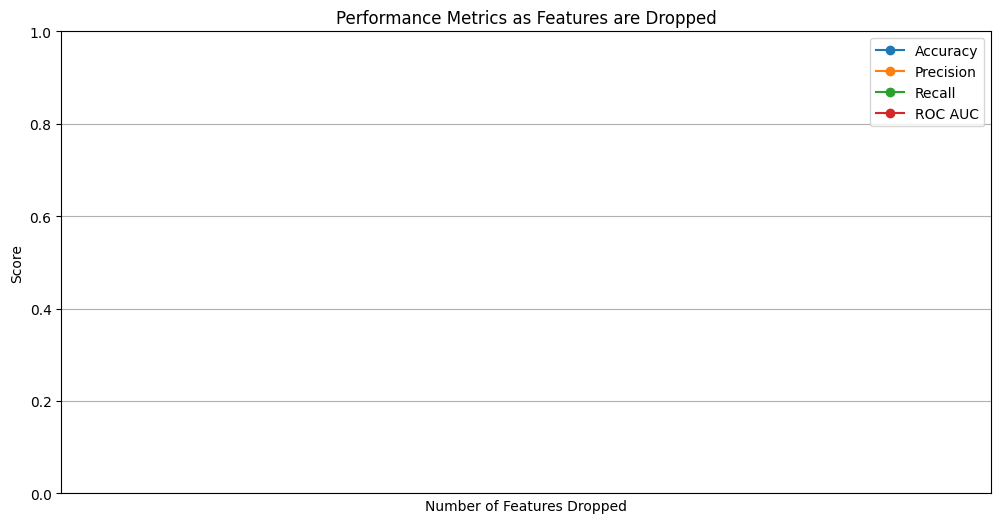

Final Selected Features: ['Market Capitalization', 'Enterprise Value', 'PE Ratio', 'PS Ratio', 'PB Ratio', 'P/FCF Ratio', 'P/OCF Ratio', 'EV/Sales Ratio', 'EV/EBITDA Ratio', 'EV/EBIT Ratio', 'EV/FCF Ratio', 'Debt / Equity Ratio', 'Debt / EBITDA Ratio', 'Debt / FCF Ratio', 'Quick Ratio', 'Current Ratio', 'Asset Turnover', 'Return on Equity (ROE)', 'Return on Assets (ROA)', 'Return on Capital (ROIC)', 'Earnings Yield', 'FCF Yield', 'Dividend Yield', 'Payout Ratio', 'Buyback Yield / Dilution', 'Total Shareholder Return', 'Debt Issuance']
Final Model Performance - Accuracy=0.8200, Precision=0.7143, Recall=0.6667, ROC AUC=0.8267, F1 Score = 0.6474

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87        35
           1       0.71      0.67      0.69        15

    accuracy                           0.82        50
   macro avg       0.79      0.78      0.78        50
weighted avg       0.82      0.82      0.82        50

In [75]:
# Extract best parameters from the existing model
best_params = best_model_cb.get_params()

# Create a new CatBoost model with the best parameters
new_model = CatBoostClassifier(**best_params)

# Fit the new model on the original training data
new_model.fit(X_train_scaled, y_train)

selected_features = list(X_train_scaled.columns)

# Store metrics
metrics = {
    'Features Dropped': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'ROC AUC': [],
    'Dropped Features': [],  # To store dropped features for each iteration
    'F1 Score': []
}

# Set stopping criteria
min_roc_auc_threshold = 0.8  # Stop if ROC AUC falls below this value
best_roc_auc = 0  # Initialize best ROC AUC

# Start backward selection
while len(selected_features) > 1:
    # Create a dictionary to store ROC AUC for each feature removal
    feature_roc_auc_scores = {}
    
    # Iterate over each feature and try removing it
    for feature in selected_features:
        # Select all features except the current one
        remaining_features = [f for f in selected_features if f != feature]
        
        # Train the model on the remaining features
        new_model.fit(X_train_scaled[remaining_features], y_train)
        
        # Make predictions on the test set
        y_pred_proba = new_model.predict_proba(X_test_scaled[remaining_features])[:, 1]
        
        # Calculate ROC AUC
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        
        # Store ROC AUC for the feature removal
        feature_roc_auc_scores[feature] = roc_auc
    
    # Find the feature whose removal results in the lowest ROC AUC
    worst_feature = min(feature_roc_auc_scores, key=feature_roc_auc_scores.get)
    worst_roc_auc = feature_roc_auc_scores[worst_feature]
    
    # Check if removing the feature results in an ROC AUC below the threshold
    if worst_roc_auc < min_roc_auc_threshold:
        print(f"Stopping selection as ROC AUC fell below {min_roc_auc_threshold}.")
        break
    
    # Remove the worst feature
    selected_features.remove(worst_feature)
    
    # Train the model on the reduced feature set and store the metrics
    new_model.fit(X_train_scaled[selected_features], y_train)
    y_pred_proba = new_model.predict_proba(X_test_scaled[selected_features])[:, 1]
    
    # Calculate and store metrics
    accuracy = accuracy_score(y_test, new_model.predict(X_test_scaled[selected_features]))
    precision = precision_score(y_test, new_model.predict(X_test_scaled[selected_features]), average='binary')
    recall = recall_score(y_test, new_model.predict(X_test_scaled[selected_features]), average='binary')
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    metrics['Features Dropped'].append(len(X_train_scaled.columns) - len(selected_features))  # Track the number of dropped features
    metrics['Accuracy'].append(accuracy)
    metrics['Precision'].append(precision)
    metrics['Recall'].append(recall)
    metrics['ROC AUC'].append(roc_auc)
    metrics['Dropped Features'].append(worst_feature)

    # Safely calculate F1 score
    if precision + recall == 0:
        f1_score = 0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)
    metrics['F1 Score'].append(f1_score)

    print(f"Iteration {len(X_train_scaled.columns) - len(selected_features)}: Dropped Feature: {worst_feature}, ROC AUC: {roc_auc:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
    
    # Update best ROC AUC
    best_roc_auc = roc_auc

# Convert metrics to a DataFrame for easy plotting
metrics_df = pd.DataFrame(metrics)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(metrics_df['Features Dropped'], metrics_df['Accuracy'], marker='o', label='Accuracy')
plt.plot(metrics_df['Features Dropped'], metrics_df['Precision'], marker='o', label='Precision')
plt.plot(metrics_df['Features Dropped'], metrics_df['Recall'], marker='o', label='Recall')
plt.plot(metrics_df['Features Dropped'], metrics_df['ROC AUC'], marker='o', label='ROC AUC')
plt.title('Performance Metrics as Features are Dropped')
plt.xlabel('Number of Features Dropped')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(metrics_df['Features Dropped'])
plt.legend()
plt.grid()
plt.show()

# Output the final selected features
print("Final Selected Features:", selected_features)

# Train the final model on the selected features
new_model.fit(X_train_scaled[selected_features], y_train)

# Evaluate on the test set
y_pred = new_model.predict(X_test_scaled[selected_features])
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
roc_auc = roc_auc_score(y_test, new_model.predict_proba(X_test_scaled[selected_features])[:, 1])

print(f'Final Model Performance - Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, ROC AUC={roc_auc:.4f}, F1 Score = {f1_score:.4f}')
# Generate and print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Generate and print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

## Sector Analysis

In [73]:
selected_columns = X_test.iloc[:, :3]

# Convert y_test and y_pred to DataFrame
y_test_df = pd.DataFrame(y_test, columns=['Default'])  
y_pred_df = pd.DataFrame(y_pred, columns=['Predicted'])  

# Concatenate y_test, y_pred, and selected columns from X_test
sector_prediction = pd.concat([y_test_df.reset_index(drop=True), 
                         y_pred_df.reset_index(drop=True), 
                         selected_columns.reset_index(drop=True)], axis=1)

# # Display the new dataset
# print(sector_prediction)

# Optionally, save the dataset to a CSV file
sector_prediction.to_csv('sector_2.csv', index=False)

# Filter rows where the actual target doesn't match the predicted value
misclassified_rows = sector_prediction[sector_prediction['Default'] != sector_prediction['Predicted']]

# Display the subset of misclassified rows
print(misclassified_rows)

# Optionally, save the misclassified rows to a CSV file
misclassified_rows.to_csv('misclassified_rows_2.csv', index=False)


    Default  Predicted                   Company Ticker  Year
2         0          1    NACCO Industries, Inc.     NC  2023
12        1          0                 Viad Corp    VVI  2023
22        0          1  Tile Shop Holdings, Inc.   TTSH  2023
23        1          0               Monro, Inc.   MNRO  2023
26        1          0    Sonic Automotive, Inc.    SAH  2023
37        0          1      Calavo Growers, Inc.   CVGW  2023
38        0          1               Alico, Inc.   ALCO  2023
42        1          0             SkyWest, Inc.   SKYW  2023
49        1          0         Limoneira Company   LMNR  2023


## Explainable AI

SHAP

In [76]:
X_test_scaled.columns

Index(['Market Capitalization', 'Enterprise Value', 'PE Ratio', 'PS Ratio',
       'PB Ratio', 'P/FCF Ratio', 'P/OCF Ratio', 'EV/Sales Ratio',
       'EV/EBITDA Ratio', 'EV/EBIT Ratio', 'EV/FCF Ratio',
       'Debt / Equity Ratio', 'Debt / EBITDA Ratio', 'Debt / FCF Ratio',
       'Quick Ratio', 'Current Ratio', 'Asset Turnover',
       'Return on Equity (ROE)', 'Return on Assets (ROA)',
       'Return on Capital (ROIC)', 'Earnings Yield', 'FCF Yield',
       'Dividend Yield', 'Payout Ratio', 'Buyback Yield / Dilution',
       'Total Shareholder Return', 'Debt Issuance'],
      dtype='object')

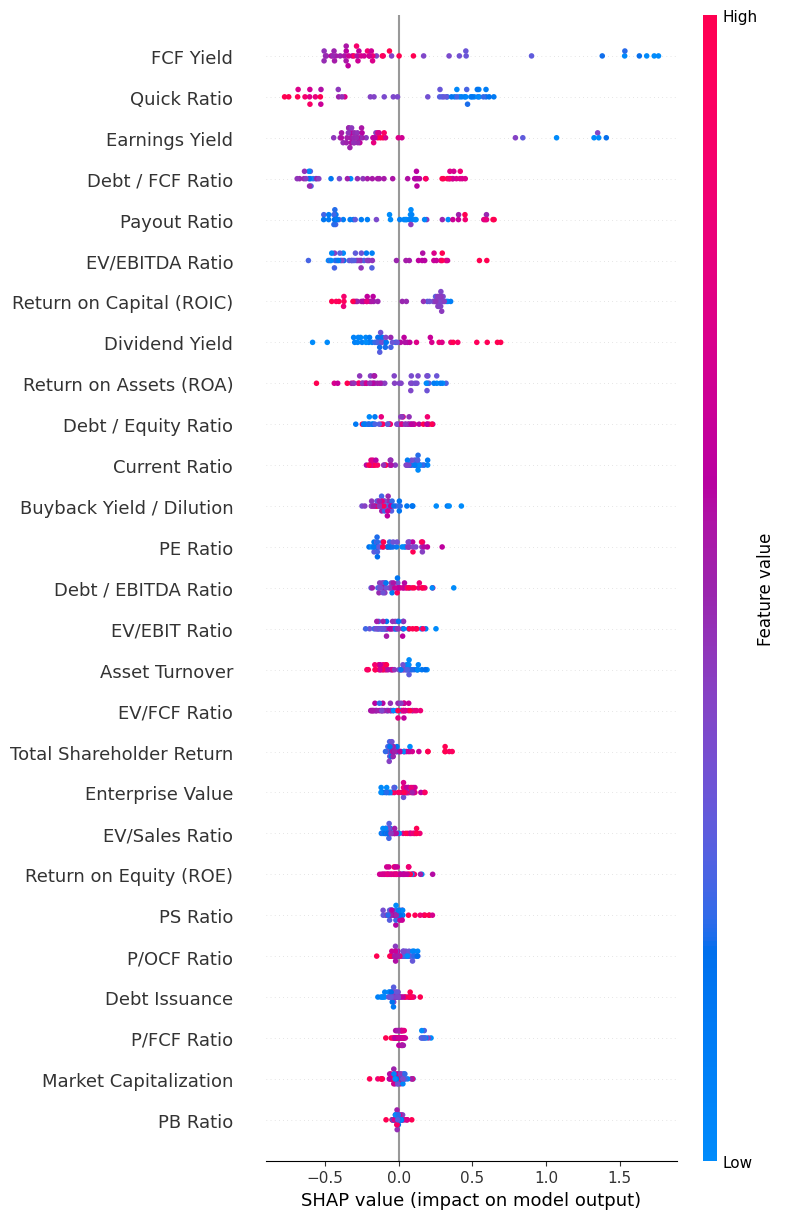

In [77]:
explainer = shap.TreeExplainer(new_model)
shap_values = explainer.shap_values(X_test_scaled)
shap.summary_plot(shap_values, X_test_scaled, max_display=27)

Permutation Importance

In [78]:
result = permutation_importance(new_model, X_test_scaled, y_test, n_repeats=10, random_state=42)
feature_importances = pd.DataFrame(result.importances_mean, index=X_test_scaled.columns, columns=['Importance'])
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)

                            Importance
Quick Ratio               5.600000e-02
Payout Ratio              5.200000e-02
Earnings Yield            4.800000e-02
Buyback Yield / Dilution  4.400000e-02
FCF Yield                 3.800000e-02
Return on Capital (ROIC)  3.600000e-02
EV/EBITDA Ratio           3.200000e-02
EV/FCF Ratio              3.200000e-02
Debt / FCF Ratio          2.600000e-02
PE Ratio                  2.600000e-02
Return on Assets (ROA)    2.600000e-02
Dividend Yield            2.200000e-02
Current Ratio             1.600000e-02
Market Capitalization     1.200000e-02
Debt / Equity Ratio       6.000000e-03
PB Ratio                  4.000000e-03
Debt Issuance             4.000000e-03
Return on Equity (ROE)    4.000000e-03
Total Shareholder Return  2.000000e-03
Debt / EBITDA Ratio       2.000000e-03
Enterprise Value          0.000000e+00
P/FCF Ratio              -1.110223e-17
EV/EBIT Ratio            -4.000000e-03
P/OCF Ratio              -4.000000e-03
PS Ratio                 

Partial Dependency Plots


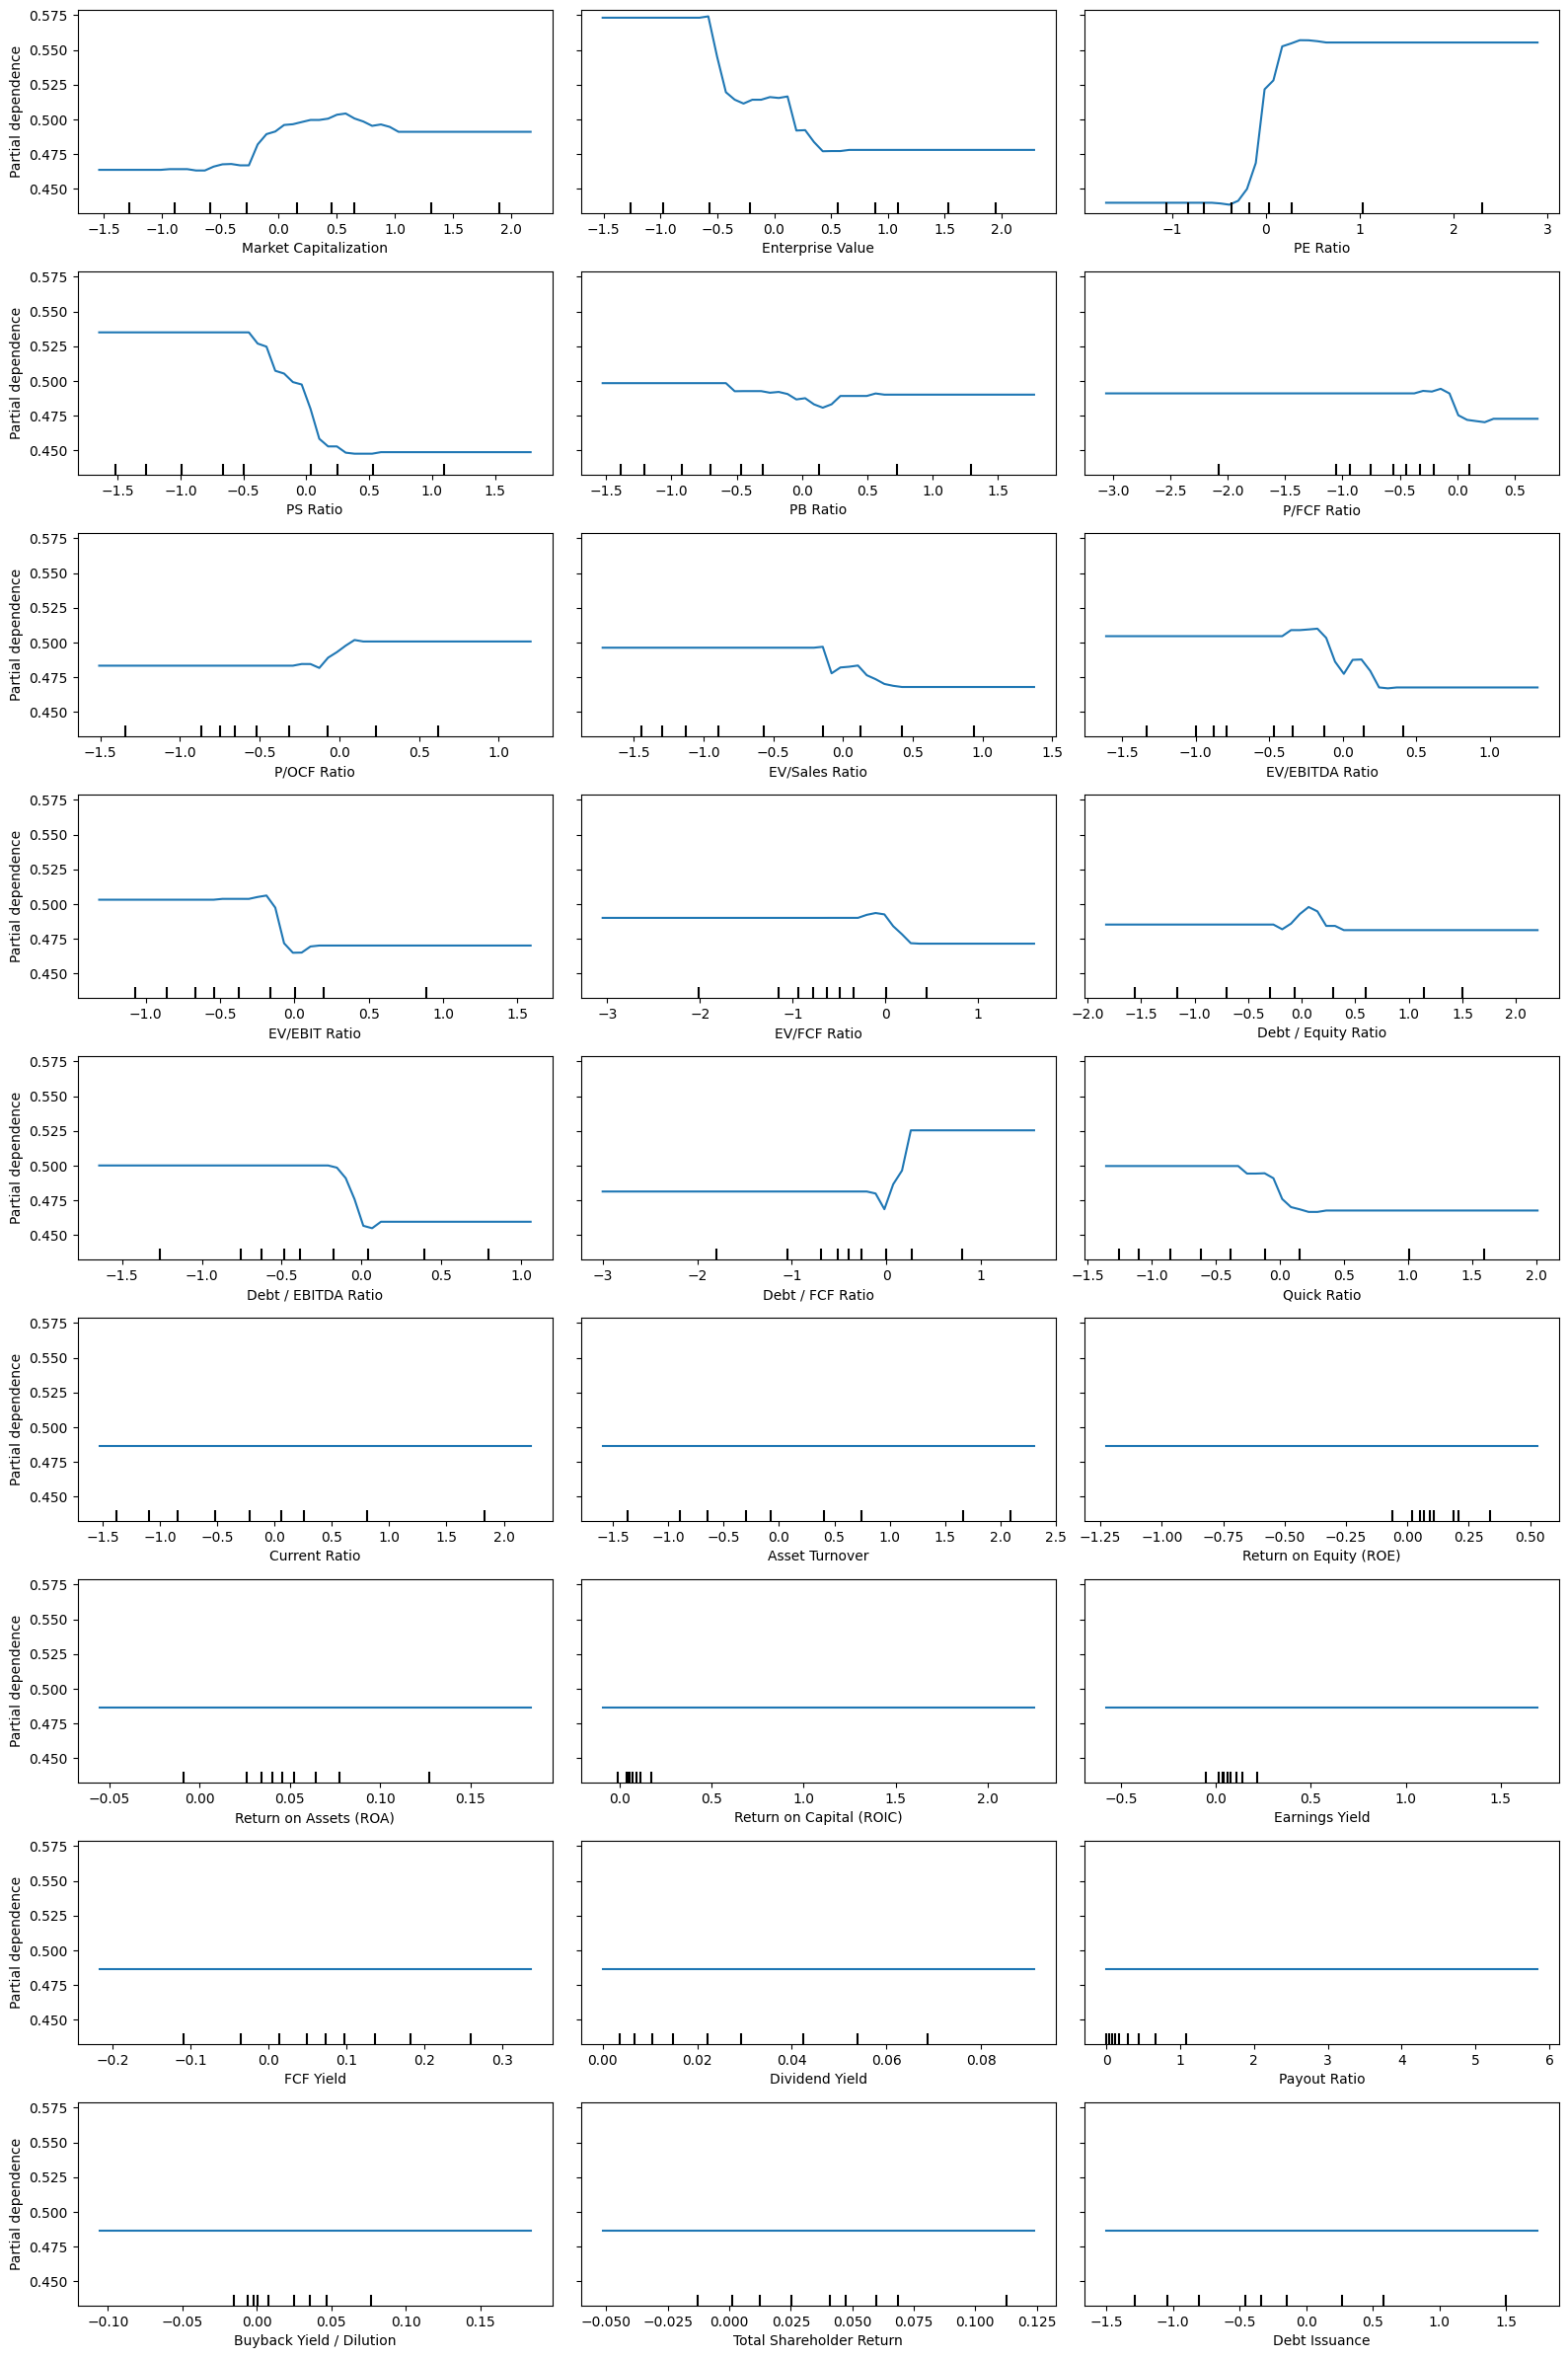

In [79]:
# Define the number of rows and columns
n_features = 27
n_cols = 3  # Number of columns (4 features per row)
n_rows = n_features // n_cols  # Calculate number of rows needed

# Plot partial dependence plots with 7 rows and 4 columns
fig, ax = plt.subplots(n_rows, n_cols, figsize=(16, 24))  # Adjust the size to fit all plots

PartialDependenceDisplay.from_estimator(
    best_model_cb,  # Your trained CatBoost model
    X_test_scaled,  # The training data
    features=list(range(n_features)),  # Select all features to plot
    ax=ax,  # Pass the ax to fit the grid layout
    grid_resolution=50  # You can adjust this value as needed for smooth curves
)

plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()

A low PE Ratio seems to correlate with a higher probability of default (a steep increase as PE Ratio decreases).

A decrease in EV/EBITDA below zero also seems to significantly increase the risk of default.

For EV/Sales Ratio, as it moves from negative to positive, the default probability rises steeply.

Buyback Yield / Dilution: This feature shows a notable pattern where the default probability sharply decreases around a specific threshold. After a point (~0.05), further increases in the buyback yield do not seem to affect the probability much.

Debt Ratios (e.g., Debt/EBITDA): Higher debt ratios tend to increase the default probability significantly after a certain threshold, reflecting the increased financial risk companies face with higher leverage.

Features like ROE, Payout Ratio, and Dividend Yield, which have flat or very minor changes, might be less critical to the prediction. 

Individual Conditional Expectation Plots

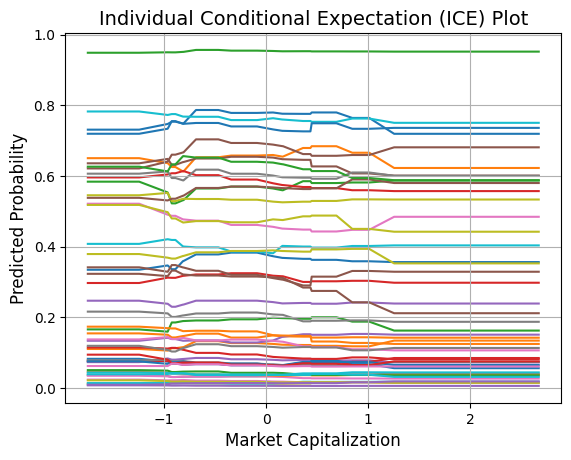

In [39]:
feature_name = 'Market Capitalization'  # Replace with your desired feature name

# Generate ICE DataFrame
ice_df = ice(X_test_scaled, column=feature_name, predict=lambda x: new_model.predict_proba(x)[:, 1])

ice_plot(ice_df)

# Label the axes
plt.xlabel(feature_name, fontsize=12)  # X-axis label
plt.ylabel('Predicted Probability', fontsize=12)  # Y-axis label
plt.title('Individual Conditional Expectation (ICE) Plot', fontsize=14)  # Title

# Show the plot
plt.grid()
plt.show()

Catboost Feature Importance and Accumulated Local Effects

In [40]:
# Step 1: Get feature importance
feature_importance = new_model.get_feature_importance(prettified=True)

# Display feature importance
print(feature_importance)

                  Feature Id  Importances
0                  FCF Yield     9.348130
1             Earnings Yield     8.724030
2               Payout Ratio     8.008602
3                Quick Ratio     7.976986
4           Debt / FCF Ratio     5.771758
5            EV/EBITDA Ratio     5.701632
6     Return on Assets (ROA)     5.189608
7             Dividend Yield     4.636033
8   Return on Capital (ROIC)     4.205842
9              EV/EBIT Ratio     3.981977
10  Buyback Yield / Dilution     3.497432
11                  PE Ratio     3.394917
12       Debt / Equity Ratio     3.351292
13       Debt / EBITDA Ratio     3.279271
14             Current Ratio     2.451268
15    Return on Equity (ROE)     2.403837
16              EV/FCF Ratio     2.378737
17                  PS Ratio     2.273928
18     Market Capitalization     1.994788
19            Asset Turnover     1.907785
20  Total Shareholder Return     1.828977
21          Enterprise Value     1.724257
22               P/OCF Ratio     1

PyALE._ALE_generic:INFO: Continuous feature detected.


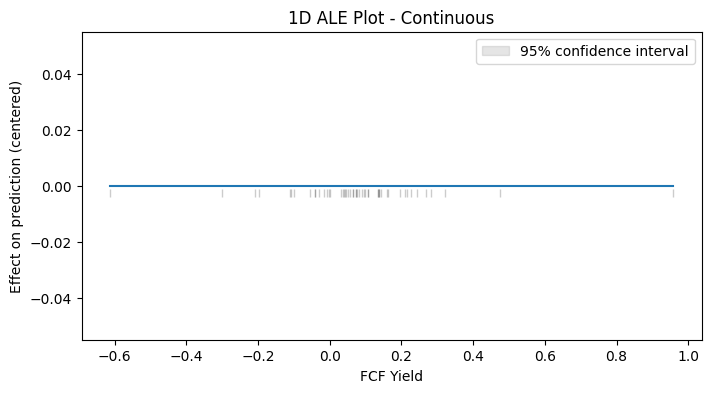

In [41]:
# Create ALE plot with confidence intervals
ale_data = ale(X=X_test_scaled, model= new_model, feature=["FCF Yield"], grid_size=50, include_CI=True, C=0.95)

PyALE._ALE_generic:INFO: Continuous feature detected.


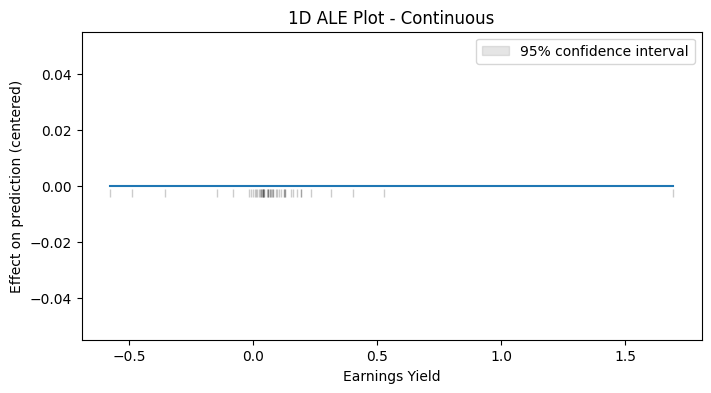

In [42]:
# Create ALE plot with confidence intervals
ale_data = ale(X=X_test_scaled, model= new_model, feature=["Earnings Yield"], grid_size=50, include_CI=True, C=0.95)

PyALE._ALE_generic:INFO: Continuous feature detected.


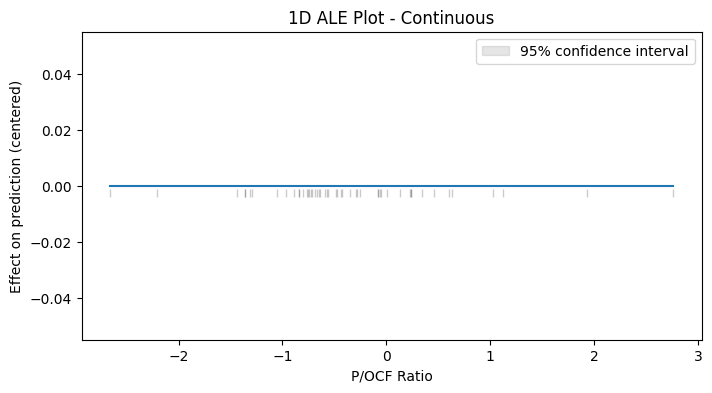

In [43]:
# Create ALE plot with confidence intervals
ale_data = ale(X=X_test_scaled, model= new_model, feature=["P/OCF Ratio"], grid_size=50, include_CI=True, C=0.95)